In [152]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [153]:
src_dir_path = '/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M'
pca_best_file_names = [
    '014_MSL_id_13_Sensor_tr_1525_1st_4575.csv',
    '017_MSL_id_16_Sensor_tr_512_1st_1850.csv',
    '074_SMD_id_18_Facility_tr_7174_1st_21230.csv',
    '079_LTDB_id_1_Medical_tr_3618_1st_3718.csv',
    '087_SVDB_id_4_Medical_tr_5421_1st_5521.csv',
    '092_SVDB_id_9_Medical_tr_2674_1st_2774.csv',
    '093_SVDB_id_10_Medical_tr_500_1st_37.csv',
    '097_SVDB_id_14_Medical_tr_1031_1st_1131.csv',
    '099_SVDB_id_16_Medical_tr_1115_1st_1215.csv',
    '101_SVDB_id_18_Medical_tr_1851_1st_1951.csv',
    '105_SVDB_id_22_Medical_tr_500_1st_417.csv',
    '108_SVDB_id_25_Medical_tr_1238_1st_1338.csv',
    '111_SVDB_id_28_Medical_tr_1791_1st_1891.csv',
    '133_OPPORTUNITY_id_5_HumanActivity_tr_1745_1st_6500.csv',
    '158_SMAP_id_15_Sensor_tr_2075_1st_5610.csv',
    '159_SMAP_id_16_Sensor_tr_1757_1st_2650.csv',
    '167_SMAP_id_24_Sensor_tr_2094_1st_5600.csv',
    '168_SMAP_id_25_Sensor_tr_1998_1st_2098.csv',
]
pca_worst_file_names = [
    '065_SMD_id_9_Facility_tr_737_1st_837.csv',
    '073_SMD_id_17_Facility_tr_5926_1st_10620.csv',
    '078_SMD_id_22_Facility_tr_500_1st_326.csv',
    '115_PSM_id_1_Facility_tr_50000_1st_129872.csv',
    '130_OPPORTUNITY_id_2_HumanActivity_tr_1045_1st_1145.csv',
    '144_SMAP_id_1_Sensor_tr_2052_1st_5300.csv',
    '173_GECCO_id_1_Sensor_tr_16165_1st_16265.csv'
]

In [154]:
print(len(pca_best_file_names), len(pca_worst_file_names))

18 7


In [155]:
pca_best_file_paths = [os.path.join(src_dir_path, file_name) for file_name in pca_best_file_names]
pca_worst_file_paths = [os.path.join(src_dir_path, file_name) for file_name in pca_worst_file_names]

In [156]:
def get_anomaly_sequences(file_path, zero_pruning=False):
    # Read the CSV file
    df = pd.read_csv(file_path)
    data = df.iloc[:, :-1].values.astype(float)  # Exclude the last column (label)
    label = df['Label'].astype(int).to_numpy() # 0: normal, 1: anomaly

    if zero_pruning:
        # Remove columns with all zeros
        non_zero_columns = np.any(data != 0, axis=0)
        data = data[:, non_zero_columns]
        
    # Find anomaly sequences in the 'label'
    anomaly_indices = np.where(label == 1)[0]
    #print(f"Anomaly indices: {anomaly_indices}")

    anomaly_sequences = []
    # Determine continuous anomaly sequences
    if anomaly_indices.size > 0:
        start_idx = anomaly_indices[0]
        prev_idx  = start_idx
        for idx in anomaly_indices[1:]:
            if idx == prev_idx + 1:
                prev_idx = idx
            else:
                anomaly_sequences.append((start_idx, prev_idx))
                start_idx = idx
                prev_idx  = idx
        anomaly_sequences.append((start_idx, prev_idx))

    return data, anomaly_sequences

In [157]:
def get_variance_of_sliding_window(data, anomaly_sequences, window_size=100, stride=1):
    variances = []
    for start, end in anomaly_sequences:
        window_start = max(0, start - window_size)
        window_end = min(len(data), end + window_size)
        # Ensure the window size is valid
        if window_end - window_start < window_size:
            continue
        # Extract the sliding window
        window_data = data[window_start:window_end]
        # Calculate the variance of each column in the window
        window_variance = np.var(window_data, axis=0)
        # Append the variance to the list
        variances.append(window_variance)
    return np.array(variances)

In [158]:
def get_statistics(file_paths, keywords_to_include, keywords_to_exclude, show=False):
    statistics = []
    for file_path in file_paths:
        if any(keyword in file_path for keyword in keywords_to_exclude):
            continue
        if not any(keyword in file_path for keyword in keywords_to_include):
            continue
        data, anomaly_sequences = get_anomaly_sequences(file_path, zero_pruning=False)
        variances = get_variance_of_sliding_window(data, anomaly_sequences, window_size=100, stride=1)
        stat_tup = (variances.mean(axis=0), variances.std(axis=0), variances.max(axis=0), variances.min(axis=0))
        statistics.append(stat_tup)
        if show:
            file_name = os.path.basename(file_path)
            print(f'File: {file_name}')
            print(f'Mean: {variances.mean(axis=0)} | Std: {variances.std(axis=0)} | Max: {variances.max(axis=0)} | Min: {variances.min(axis=0)}')
            print('-----------------------------------')
    return statistics

In [159]:
keywords_to_include = ['074_SMD', '167_SMAP']
keywords_to_exclude = []
pca_best_stat = get_statistics(pca_best_file_paths, keywords_to_include, keywords_to_exclude, show=False)

In [160]:
keywords_to_include = ['065_SMD', '144_SMAP']
keywords_to_exclude = []
pca_worst_stat = get_statistics(pca_worst_file_paths, keywords_to_include, keywords_to_exclude, show=False)

In [161]:
def plot_statistics(best_stat, worst_stat, title=None):
    best_mean, worst_mean = best_stat[0], worst_stat[0]
    best_std, worst_std = best_stat[1], worst_stat[1]
    best_max, worst_max = best_stat[2], worst_stat[2]
    best_min, wosrt_min = best_stat[3], worst_stat[3]

    # Subplots 2x2
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'{title}') if title else fig.suptitle('Statistics Comparison')
    # Axis 1: Mean with plot()
    axs[0, 0].plot(best_mean, label='PCA Best Mean', color='blue')
    axs[0, 0].plot(worst_mean, label='PCA Worst Mean', color='red')
    axs[0, 0].set_title('Mean')
    axs[0, 0].set_xlabel('Feature Index')
    axs[0, 0].set_ylabel('Mean Value')
    axs[0, 0].legend()

    # Axis 2: Std with plot()
    axs[0, 1].plot(best_std, label='PCA Best Std', color='blue')
    axs[0, 1].plot(worst_std, label='PCA Worst Std', color='red')
    axs[0, 1].set_title('Standard Deviation')
    axs[0, 1].set_xlabel('Feature Index')
    axs[0, 1].set_ylabel('Std Value')
    axs[0, 1].legend()

    # Axis 3: Max with plot()
    axs[1, 0].plot(best_max, label='PCA Best Max', color='blue')
    axs[1, 0].plot(worst_max, label='PCA Worst Max', color='red')
    axs[1, 0].set_title('Max')
    axs[1, 0].set_xlabel('Feature Index')
    axs[1, 0].set_ylabel('Max Value')
    axs[1, 0].legend()

    # Axis 4: Min with plot()
    axs[1, 1].plot(best_min, label='PCA Best Min', color='blue')
    axs[1, 1].plot(wosrt_min, label='PCA Worst Min', color='red')
    axs[1, 1].set_title('Min')
    axs[1, 1].set_xlabel('Feature Index')
    axs[1, 1].set_ylabel('Min Value')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()    

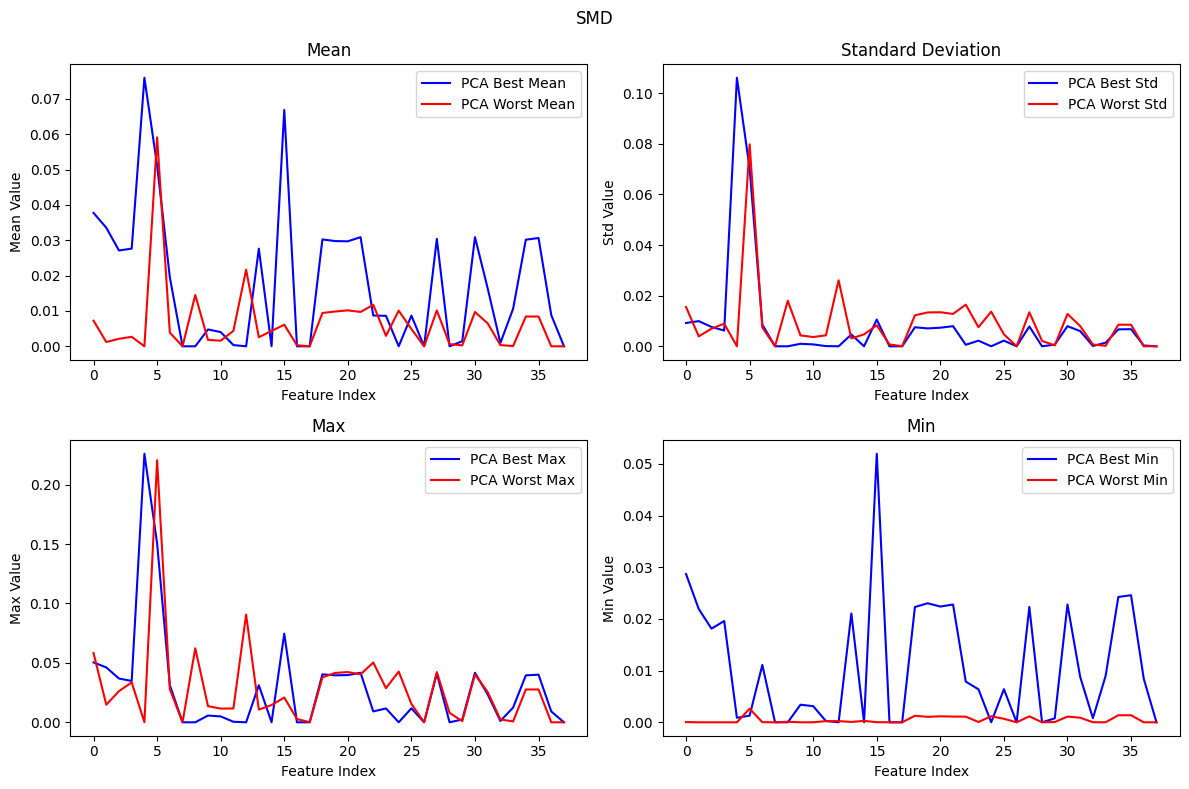

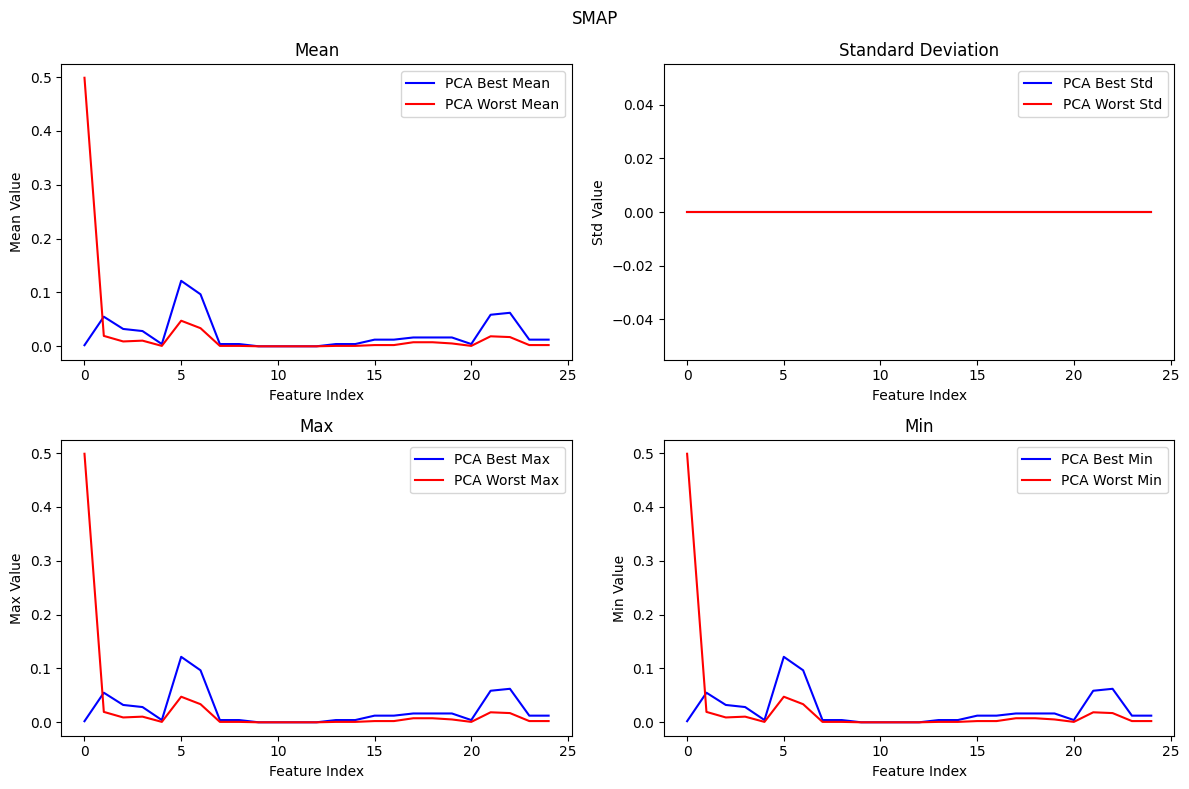

In [162]:
for best_stat, worst_stat, keyword in zip(pca_best_stat, pca_worst_stat, keywords_to_include):
    ts_name = keyword.split('_')[1]
    plot_statistics(best_stat, worst_stat, title=ts_name)